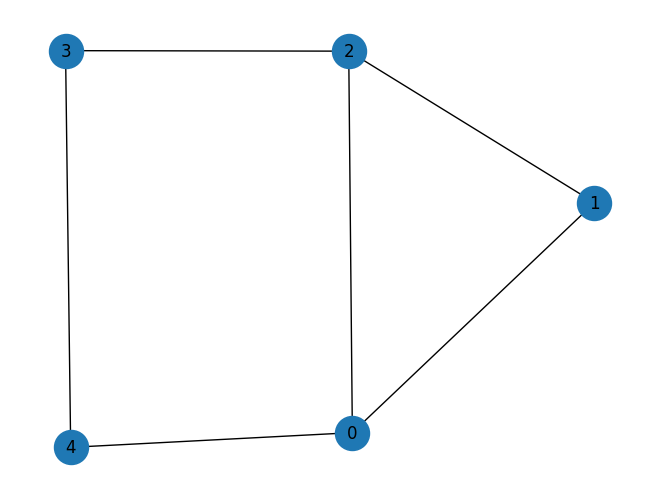

In [33]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np

n = 5

graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [34]:
from qiskit.quantum_info import SparsePauliOp
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list


max_cut_paulis = build_max_cut_paulis(graph)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


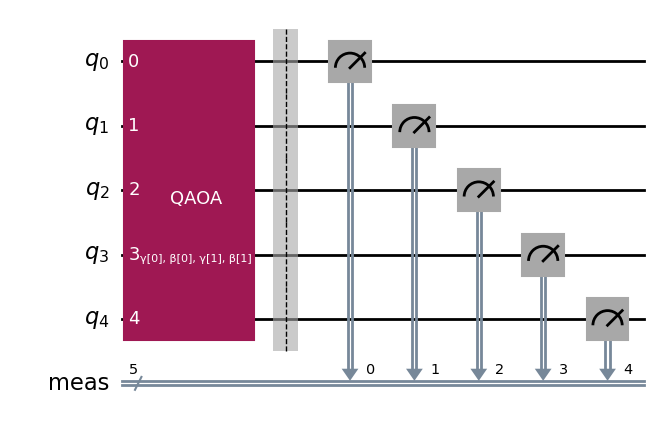

In [35]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()

circuit.draw('mpl')

In [36]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])

TSP Hamiltonian:
 SparsePauliOp(['ZZZZZIIIIIIIIIIIIIIIIIIII', 'IIIIIZZZZZIIIIIIIIIIIIIII', 'IIIIIIIIIIZZZZZIIIIIIIIII', 'IIIIIIIIIIIIIIIZZZZZIIIII', 'IIIIIIIIIIIIIIIIIIIIZZZZZ', 'ZIIIIZIIIIZIIIIZIIIIZIIII', 'IZIIIIZIIIIZIIIIZIIIIZIII', 'IIZIIIIZIIIIZIIIIZIIIIZII', 'IIIZIIIIZIIIIZIIIIZIIIIZI', 'IIIIZIIIIZIIIIZIIIIZIIIIZ', 'ZIIIIIZIIIIIIIIIIIIIIIIII', 'IZIIIIIZIIIIIIIIIIIIIIIII', 'IIZIIIIIZIIIIIIIIIIIIIIII', 'IIIZIIIIIZIIIIIIIIIIIIIII', 'IIIIZZIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIIZIIIIIIIIIIIII', 'IZIIIIIIIIIIZIIIIIIIIIIII', 'IIZIIIIIIIIIIZIIIIIIIIIII', 'IIIZIIIIIIIIIIZIIIIIIIIII', 'IIIIZIIIIIZIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIIIZIIIIIIII', 'IZIIIIIIIIIIIIIIIZIIIIIII', 'IIZIIIIIIIIIIIIIIIZIIIIII', 'IIIZIIIIIIIIIIIIIIIZIIIII', 'IIIIZIIIIIIIIIIZIIIIIIIII', 'ZIIIIIIIIIIIIIIIIIIIIZIII', 'IZIIIIIIIIIIIIIIIIIIIIZII', 'IIZIIIIIIIIIIIIIIIIIIIIZI', 'IIIZIIIIIIIIIIIIIIIIIIIIZ', 'IIIIZIIIIIIIIIIIIIIIZIIII', 'IIIIIZIIIIIZIIIIIIIIIIIII', 'IIIIIIZIIIIIZIIIIIIIIIIII', 'IIIIIIIZIIIIIZIIIIIIIIIII', 'IIIIIIIIZ

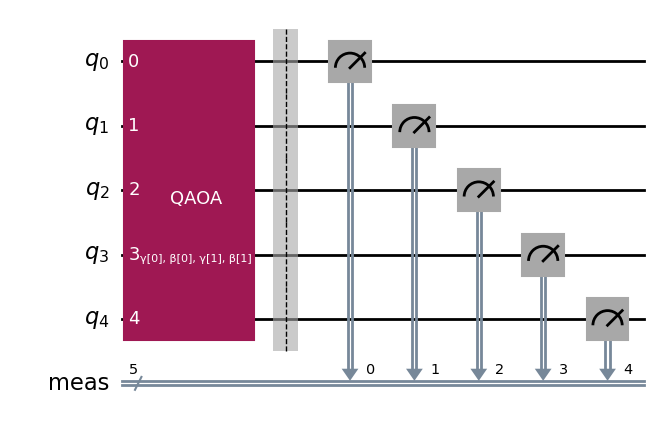

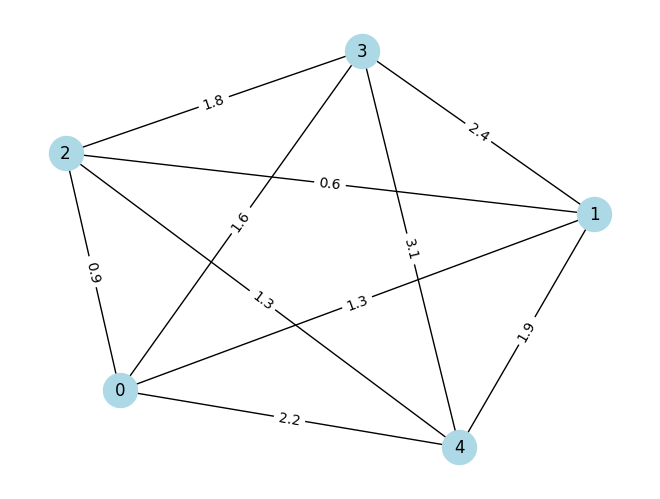

In [37]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import networkx as nx

# --- TSP Problem Definition ---
cities = ["A", "B", "C", "D", "E"]
distance_matrix = np.array([
    [0, 1.3, 0.9, 1.6, 2.2],
    [1.3, 0, 0.6, 2.4, 1.9],
    [0.9, 0.6, 0, 1.8, 1.3],
    [1.6, 2.4, 1.8, 0, 3.1],
    [2.2, 1.9, 1.3, 3.1, 0]
])

# --- Create TSP Graph ---
n = len(cities)
tsp_graph = rx.PyGraph()
tsp_graph.add_nodes_from(range(n))

# Add edges with weights (distances)
for i in range(n):
    for j in range(i+1, n):
        tsp_graph.add_edge(i, j, distance_matrix[i][j])

# Draw the TSP graph
draw_graph(tsp_graph, node_size=600, with_labels=True, 
           node_color='lightblue', edge_labels=lambda x: f"{x:.1f}")

# --- Build TSP Hamiltonian ---
def build_tsp_hamiltonian(graph: rx.PyGraph, penalty=1000) -> SparsePauliOp:
    """Build Hamiltonian for TSP as sum of 3 components"""
    n = len(graph.nodes())
    
    # 1. Constraint: Each city visited exactly once
    h_city = []
    for i in range(n):
        pauli_str = ["I"] * n**2
        for t in range(n):
            idx = i * n + t
            pauli_str[idx] = "Z"
        h_city.append(("".join(pauli_str), penalty * (1 - 2/n)))
    
    # 2. Constraint: Each time slot has exactly one city
    h_time = []
    for t in range(n):
        pauli_str = ["I"] * n**2
        for i in range(n):
            idx = i * n + t
            pauli_str[idx] = "Z"
        h_time.append(("".join(pauli_str), penalty * (1 - 2/n)))
    
    # 3. Objective: Minimize travel distance
    h_dist = []
    for edge in graph.edge_list():
        i, j = edge
        weight = graph.get_edge_data(i, j)
        for t in range(n):
            pauli_str = ["I"] * n**2
            idx_i = i * n + t
            idx_j = j * n + ((t + 1) % n)
            pauli_str[idx_i] = "Z"
            pauli_str[idx_j] = "Z"
            h_dist.append(("".join(pauli_str), weight / 4))
    
    # Combine all terms
    return SparsePauliOp.from_list(h_city + h_time + h_dist)

# Build the Hamiltonian
tsp_hamiltonian = build_tsp_hamiltonian(tsp_graph)
print("TSP Hamiltonian:\n", tsp_hamiltonian)

circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()

circuit.draw('mpl')

In [38]:
#service = QiskitRuntimeService.save_account(
#    channel='ibm_quantum',
#    instance='ibm-q/open/main',
#    set_as_default=True,
#    overwrite=True,
#    token='e75a9afe7705589c1b41b5a5eeee0b8e9944c6fe8651b34aff6874161c277dace7b36f3153efc3f4f8ec45d197a28ba76dde19dc8118b6054119cdc2a5fbeb5b'
#)

In [39]:
from qiskit_ibm_runtime import QiskitRuntimeService
from optimized_routing.utils.backend_info import get_coupling_map_from_backend

In [40]:
service = QiskitRuntimeService()

/var/folders/94/8b3jmj1x6tbdx6dh5b9pb_9c0000gn/T/ipykernel_79200/1875822867.py:1: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService()


In [41]:
dev_list = service.backends(
    filters = lambda x: x.configuration().n_qubits >= 5,
    simulator = False)

In [42]:
print(dev_list)

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_sherbrooke')>]


In [43]:
dev = service.least_busy(min_num_qubits=5, simulator=False, operational=True)
print(dev)

<IBMBackend('ibm_sherbrooke')>


In [44]:
seed_sim = 42
noisy_fake_backend = AerSimulator.from_backend(dev, seed_simulator=seed_sim)
print(noisy_fake_backend)

AerSimulator('aer_simulator_from(ibm_sherbrooke)'
             noise_model=<NoiseModel on ['x', 'id', 'reset', 'sx', 'measure', 'ecr']>)


In [45]:
G = get_coupling_map_from_backend(noisy_fake_backend)

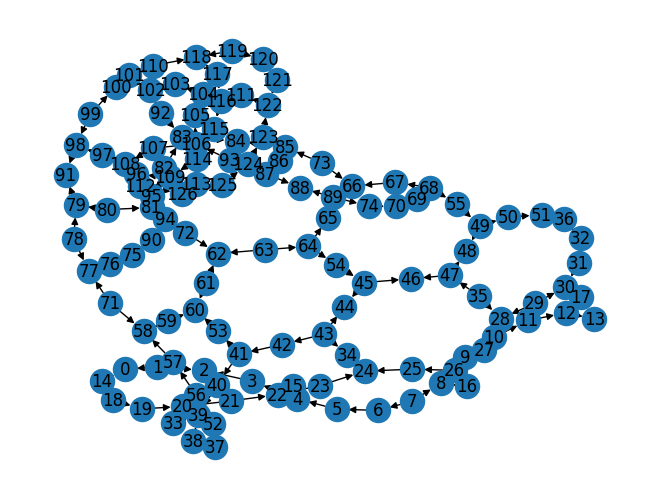

In [46]:
from rustworkx.visualization import mpl_draw

# Then you can call:
mpl_draw(G, with_labels=True)

In [47]:
from qiskit.visualization import plot_error_map

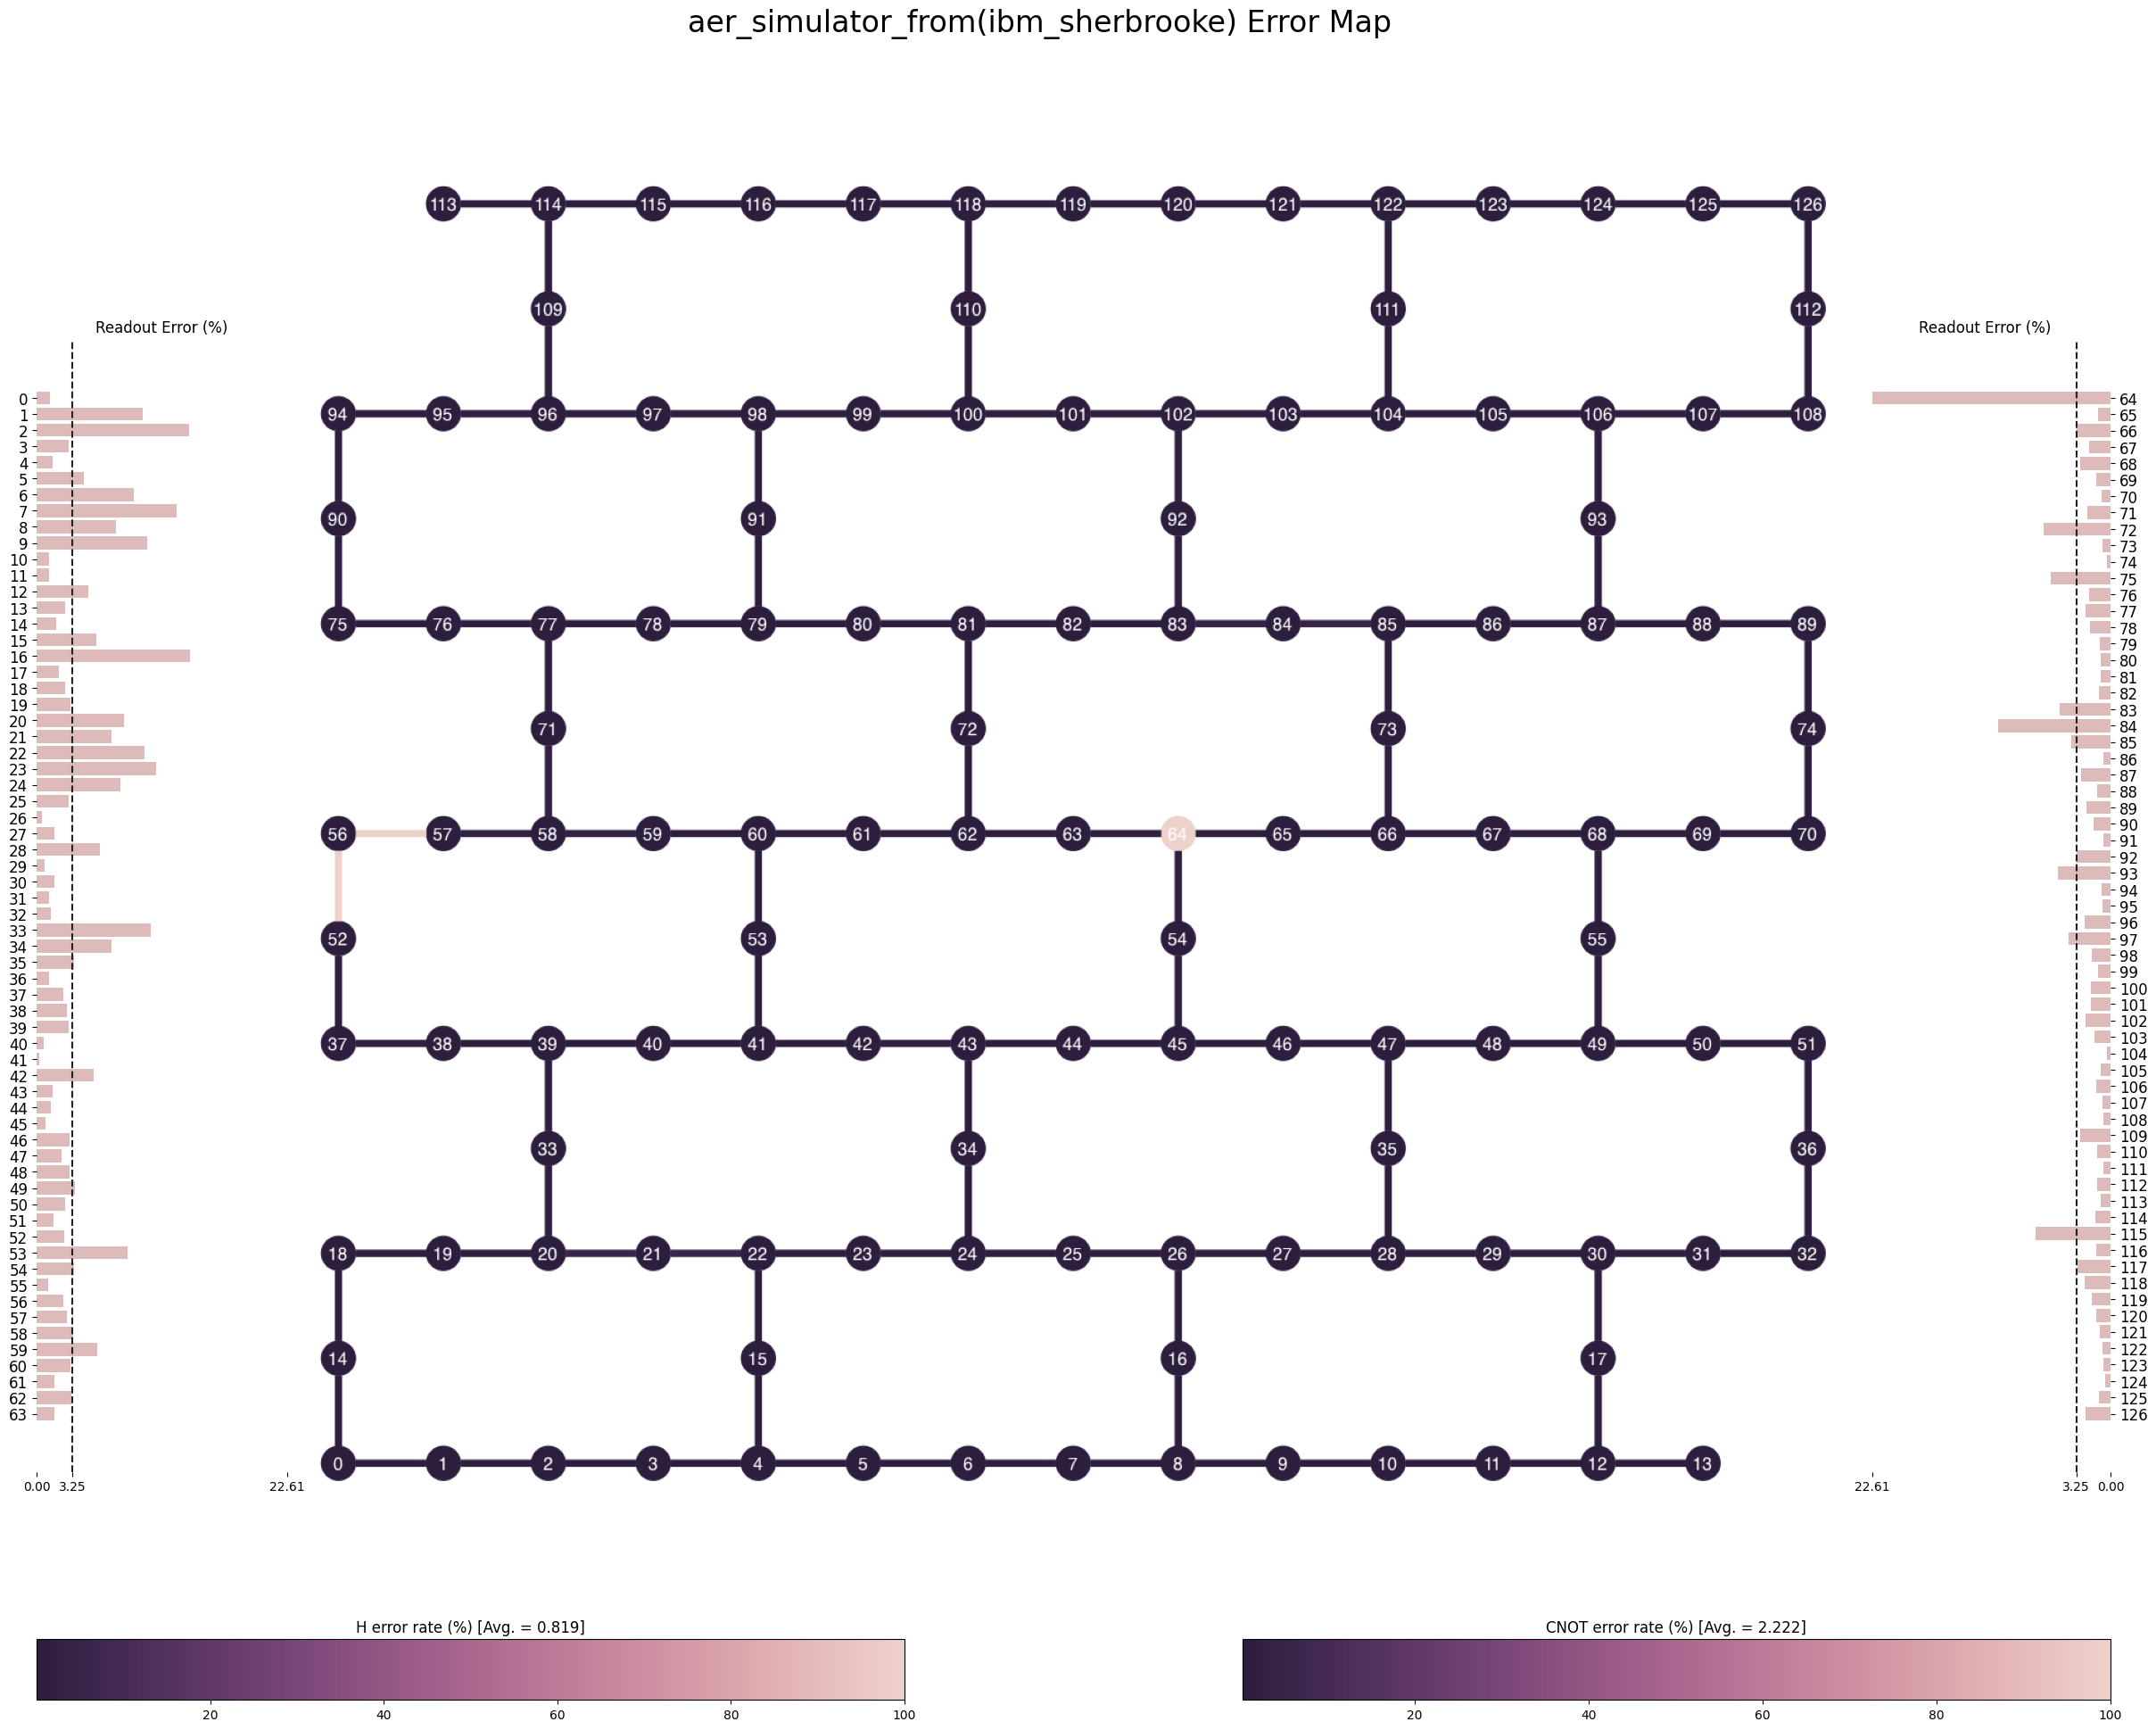

In [48]:
plot_error_map(noisy_fake_backend, figsize=(30, 24))

In [49]:
#service = QiskitRuntimeService.save_account(
#    channel='ibm_quantum',
#    instance='ibm-q/open/main',
#    set_as_default=True,
#    overwrite=True,
#    token='e75a9afe7705589c1b41b5a5eeee0b8e9944c6fe8651b34aff6874161c277dace7b36f3153efc3f4f8ec45d197a28ba76dde19dc8118b6054119cdc2a5fbeb5b'
#)

In [50]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()

backend = service.backend("ibm_brisbane")

print(f"Backend: {backend.name}, Qubits: {backend.num_qubits}")
target = backend.target
num_qubits = backend.num_qubits

/var/folders/94/8b3jmj1x6tbdx6dh5b9pb_9c0000gn/T/ipykernel_79200/1911836616.py:3: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService()


Backend: ibm_brisbane, Qubits: 127


In [63]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator
 
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
 
estimator = Estimator(backend)
options = estimator.options
# Turn on gate twirling.
options.twirling.enable_gates = True
# Turn on measurement error mitigation.
options.resilience.measure_mitigation = True
 
print(f">>> gate twirling is turned on: {estimator.options.twirling.enable_gates}")
print(f">>> measurement error mitigation is turned on: {estimator.options.resilience.measure_mitigation}")

/var/folders/94/8b3jmj1x6tbdx6dh5b9pb_9c0000gn/T/ipykernel_79200/2200441703.py:4: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService()


>>> gate twirling is turned on: True
>>> measurement error mitigation is turned on: True


In [64]:
Noise_dict = {}
read_err = [0] * num_qubits
single_gate_errors = [0] * num_qubits
two_q_error_map = {}

for inst, props in target.items():
    for qargs, inst_props in props.items():
        if inst_props is None:
            continue
        if inst == "measure":
            if inst_props.error is not None:
                read_err[qargs[0]] = inst_props.error
                Noise_dict[str(qargs[0])] = inst_props.error
        elif len(qargs) == 1:
            if inst_props.error is not None:
                single_gate_errors[qargs[0]] = max(single_gate_errors[qargs[0]], inst_props.error)
        elif len(qargs) == 2:
            if inst_props.error is not None:
                two_q_error_map[qargs] = inst_props.error

In [65]:
combined_error = [read_err[i] + single_gate_errors[i] for i in range(num_qubits)]

sorted_qubits = sorted(range(num_qubits), key=lambda i: combined_error[i])

required_logical_qubits = circuit.num_qubits
good_qubits = sorted_qubits[:required_logical_qubits]

In [66]:
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.layout import Layout

cmap = backend.coupling_map
filtered_edges = [[a, b] for [a, b] in cmap if a in good_qubits and b in good_qubits]
filtered_coupling = CouplingMap(filtered_edges)

logical_to_physical = {circuit.qubits[i]: good_qubits[i] for i in range(required_logical_qubits)}
custom_layout = Layout(logical_to_physical)

In [67]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Load your IBM Quantum account (make sure token is configured)
service = QiskitRuntimeService()

# Get IBM Brisbane backend
backend = service.backend(name="ibm_brisbane")

# Get backend properties
properties = backend.properties()

# Extract readout errors per qubit
readout_errors = {}
for qubit in range(backend.num_qubits):
    ro_error = properties.readout_error(qubit)
    if ro_error is not None:
        readout_errors[qubit] = ro_error

# Sort qubits by readout error ascending
sorted_qubits = sorted(readout_errors.items(), key=lambda x: x[1])

# Display sorted qubits
print("Qubits sorted by readout error (lowest to highest):")
for qubit, error in sorted_qubits:
    print(f"Qubit {qubit}: readout error = {error:.5f}")

/var/folders/94/8b3jmj1x6tbdx6dh5b9pb_9c0000gn/T/ipykernel_79200/1600212560.py:4: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService()


Qubits sorted by readout error (lowest to highest):
Qubit 47: readout error = 0.00488
Qubit 6: readout error = 0.00732
Qubit 103: readout error = 0.00732
Qubit 105: readout error = 0.00757
Qubit 99: readout error = 0.00781
Qubit 52: readout error = 0.00830
Qubit 31: readout error = 0.00854
Qubit 76: readout error = 0.00879
Qubit 2: readout error = 0.00928
Qubit 19: readout error = 0.00977
Qubit 61: readout error = 0.00977
Qubit 85: readout error = 0.01074
Qubit 7: readout error = 0.01099
Qubit 21: readout error = 0.01099
Qubit 28: readout error = 0.01123
Qubit 116: readout error = 0.01123
Qubit 58: readout error = 0.01147
Qubit 90: readout error = 0.01147
Qubit 110: readout error = 0.01147
Qubit 118: readout error = 0.01147
Qubit 75: readout error = 0.01172
Qubit 65: readout error = 0.01196
Qubit 69: readout error = 0.01196
Qubit 10: readout error = 0.01245
Qubit 42: readout error = 0.01245
Qubit 113: readout error = 0.01245
Qubit 125: readout error = 0.01245
Qubit 78: readout error = 

In [83]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit.circuit.library import XGate
from qiskit.transpiler import Layout
from qiskit_ibm_runtime import QiskitRuntimeService

# Connect to IBM Quantum
service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")

# Custom mapping: choose 5 best qubits by readout error
best_qubits = [47, 6, 103, 105, 99] 
qr = QuantumRegister(5, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)

# Full Adder Logic (map logical to best physical qubits)
qc.cx(qr[0], qr[3])  # a ⊕ sum
qc.cx(qr[1], qr[3])  # b ⊕ sum
qc.cx(qr[2], qr[3])  # cin ⊕ sum
qc.ccx(qr[0], qr[1], qr[4])  # carry
qc.ccx(qr[1], qr[2], qr[4])
qc.ccx(qr[0], qr[2], qr[4])
qc.measure(qr[3], cr[0])  # sum
qc.measure(qr[4], cr[1])  # carry

# Dynamical Decoupling
def insert_dd(circ, dd_sequence=None):
    if dd_sequence is None:
        dd_sequence = [XGate()]
    new_circ = QuantumCircuit(circ.num_qubits, circ.num_clbits)
    for instr, qargs, cargs in circ.data:
        new_circ.append(instr, qargs, cargs)
        for qubit in qargs:
            for gate in dd_sequence:
                new_circ.append(gate, [qubit])
    return new_circ

qc_dd = insert_dd(qc)

# Define custom layout to map
custom_layout = Layout({qr[i]: best_qubits[i] for i in range(5)})

# Transpile
qc_final = transpile(
    qc_dd,
    backend=backend,
    initial_layout=custom_layout,
    optimization_level=3,
    routing_method="sabre"
)

qc_final.draw("mpl")

/var/folders/94/8b3jmj1x6tbdx6dh5b9pb_9c0000gn/T/ipykernel_79200/547781633.py:7: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService()
/var/folders/94/8b3jmj1x6tbdx6dh5b9pb_9c0000gn/T/ipykernel_79200/547781633.py:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circ.data:
ERROR:stevedore.extension:Could not load 'ibm_backend': cannot import name 'ProviderV1' from 'qiskit.providers' (/Users/hrudaydivakaran/lab_env/lib/python3.12/

In [116]:
from qiskit.transpiler import CouplingMap, Layout
from qiskit.circuit import QuantumCircuit

def fast_custom_layout(circuit: QuantumCircuit, coupling_map: CouplingMap):
    # Quickly map qubits linearly to physical qubits
    num_qubits = circuit.num_qubits
    layout_dict = {circuit.qubits[i]: i for i in range(num_qubits)}
    return Layout(layout_dict)

In [117]:
from qiskit import transpile

custom_layout = fast_custom_layout(circuit, backend.configuration().coupling_map)

transpiled_custom = transpile(
    circuit,
    backend=backend,
    initial_layout=custom_layout,  
    optimization_level=0        
)

ERROR:stevedore.extension:Could not load 'ibm_backend': cannot import name 'ProviderV1' from 'qiskit.providers' (/Users/hrudaydivakaran/lab_env/lib/python3.12/site-packages/qiskit/providers/__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': cannot import name 'ProviderV1' from 'qiskit.providers' (/Users/hrudaydivakaran/lab_env/lib/python3.12/site-packages/qiskit/providers/__init__.py)


In [118]:
from qiskit import QuantumCircuit, transpile
from qiskit.transpiler import Layout
from qiskit_ibm_runtime import QiskitRuntimeService

# Load service and backend
service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")

circuit = QuantumCircuit(5)
circuit.h(range(5))
circuit.cx(0, 1)
circuit.cx(2, 3)
circuit.cx(3, 4)

custom_layout = Layout({circuit.qubits[i]: i for i in range(circuit.num_qubits)})

transpiled_custom = transpile(
    circuit,
    backend=backend,
    initial_layout=custom_layout,
    optimization_level=0
)

print("Depth:", transpiled_custom.depth())

/var/folders/94/8b3jmj1x6tbdx6dh5b9pb_9c0000gn/T/ipykernel_79200/588234896.py:6: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService()
ERROR:stevedore.extension:Could not load 'ibm_backend': cannot import name 'ProviderV1' from 'qiskit.providers' (/Users/hrudaydivakaran/lab_env/lib/python3.12/site-packages/qiskit/providers/__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': cannot import name 'ProviderV1' from 'qiskit.providers' (/Users/hrudaydivakaran/lab_env/lib/python3.12/site-packages/qiskit/providers/__init__.py)


Depth: 24


In [119]:
import time

def time_transpile(circuit, backend, layout=None, layout_name="custom", opt_level=0):
    start = time.time()
    transpiled = transpile(
        circuit,
        backend=backend,
        initial_layout=layout,
        layout_method=None if layout else layout_name,
        optimization_level=opt_level,
    )
    elapsed = time.time() - start
    print(f"{layout_name.capitalize()} layout | Time: {elapsed:.4f} sec | Depth: {transpiled.depth()}")
    return transpiled

ERROR:stevedore.extension:Could not load 'ibm_backend': cannot import name 'ProviderV1' from 'qiskit.providers' (/Users/hrudaydivakaran/lab_env/lib/python3.12/site-packages/qiskit/providers/__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': cannot import name 'ProviderV1' from 'qiskit.providers' (/Users/hrudaydivakaran/lab_env/lib/python3.12/site-packages/qiskit/providers/__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_backend': cannot import name 'ProviderV1' from 'qiskit.providers' (/Users/hrudaydivakaran/lab_env/lib/python3.12/site-packages/qiskit/providers/__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': cannot import name 'ProviderV1' from 'qiskit.providers' (/Users/hrudaydivakaran/lab_env/lib/python3.12/site-packages/qiskit/providers/__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_backend': cannot import name 'ProviderV1' from 'qiskit.providers' (/Users/hrudaydivakaran/lab_env/lib/python3.12/site-packag

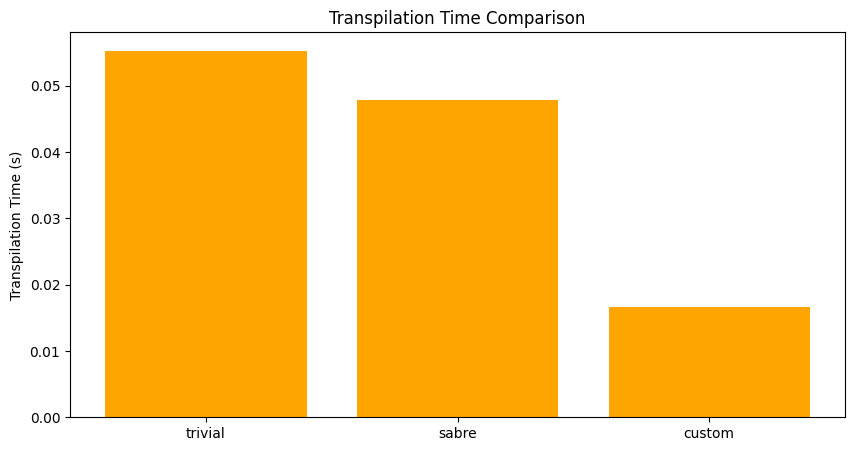

In [121]:
import matplotlib.pyplot as plt

layouts = ["trivial", "sabre"]
depths = []
times = []

# Default layouts
for layout_name in layouts:
    start = time.time()
    transpiled = transpile(circuit, backend=backend, layout_method=layout_name, optimization_level=1)
    elapsed = time.time() - start
    times.append(elapsed)
    depths.append(transpiled.depth())

# Custom layout
custom_layout = fast_custom_layout(circuit, backend.configuration().coupling_map)
start = time.time()
transpiled_custom = transpile(
    circuit,
    backend=backend,
    initial_layout=custom_layout,
    optimization_level=0,
)
elapsed = time.time() - start
times.append(elapsed)
depths.append(transpiled_custom.depth())
layouts.append("custom")

# Plot
plt.figure(figsize=(10, 5))
plt.bar(layouts, times, color='orange')
plt.ylabel("Transpilation Time (s)")
plt.title("Transpilation Time Comparison")
plt.show()